In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import pickle

import sys

import glob

## Dataset elegido: small_data_5, el modelo base: Random Forest

### Abre el dataset elegido en el notebook "baseline_models_comparison"

In [2]:
small_data_5 = pd.read_csv("../data/output_data_5/small_data_no_outliers_cols_3.csv")
small_data_5 = small_data_5.drop(["Unnamed: 0"], axis=1)
small_data_5 = small_data_5.rename({"bathrooms_text": "no_of_bathrooms"}, axis=1)
small_data_5.head()

,id,minimum_nights,availability_60,host_acceptance_rate,bedrooms,host_verifications,availability_90,ine_percent_vacation_rental,host_total_listings_count,review_scores_cleanliness,...,last_review,instant_bookable,host_is_superhost,onehot__state_Andalucía,onehot__state_Cataluña,onehot__state_Comunidad Valenciana,onehot__state_Comunidad de Madrid,onehot__state_Islas Baleares,onehot__state_País Vasco,price
0,18674,1,15,0.94,3.0,2,30,1.28,42,4.63,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,129.0
1,124342,3,17,0.43,1.0,2,47,1.28,7,4.61,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,60.0
2,128463,3,23,1.00,1.0,2,38,1.28,1,4.94,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,60.0
3,130227,31,0,1.00,3.0,2,30,1.28,1,4.92,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,80.0
4,135513,90,60,0.18,2.0,2,90,1.28,2,4.68,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,90.0


In [3]:
small_data_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            804 non-null    int64  
 1   minimum_nights                                804 non-null    int64  
 2   availability_60                               804 non-null    int64  
 3   host_acceptance_rate                          804 non-null    float64
 4   bedrooms                                      804 non-null    float64
 5   host_verifications                            804 non-null    int64  
 6   availability_90                               804 non-null    int64  
 7   ine_percent_vacation_rental                   804 non-null    float64
 8   host_total_listings_count                     804 non-null    int64  
 9   review_scores_cleanliness                     804 non-null    flo

## 1) Optimización del RandomForest con el Grid Search

### Búsqueda de mejores hiperparámetros (tarda approx 15 min.)

In [4]:
X = small_data_5.iloc[:, 1:-1]
y = small_data_5["price"]

# Split the data into train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.20,
                                                                    random_state=42)

# Standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [150, 200, 250, 300, 350, 400, 450,
                                          500]})

In [5]:
# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Best score:  0.5210554938086494


GridSearch Best Parameters and Score:
- Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
- Best score:  0.5210554938086494

Voy a probar estos hiperparámetros

In [4]:
sys.path.insert(0, '../functions')
import run_baseline_model as bm


bm.train_random_forest(X=small_data_5.iloc[:, 1:-1], y=small_data_5["price"], random_state=42, 
                       max_depth=20,
                       min_samples_leaf=1,
                       min_samples_split=2,
                       n_estimators=250,
                       path1="../data/output_optimization/small/baseline_feature_importances.csv",
                       path2="../data/output_optimization/small/metrics_1.csv")

c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  RandomForestRegressor(max_depth=20, n_estimators=250,
                                        random_state=42))]),
                 Model          MSE       RMSE        MAE       MAPE        R2
 0   RandomForest_Test  1229.402006  35.062829  25.444070  28.499282  0.485453
 1  RandomForest_Train   174.937682  13.226401   9.549586  11.553094  0.935064)

In [5]:
# Abre las métricas del modelo base
res_small_5 = pd.read_csv("../data/output_data_5/metrics_small_data_no_outliers_cols_3.csv")
res_small_5[res_small_5["MAE"] == (res_small_5["MAE"].min())]

,Model,MSE,RMSE,MAE,MAPE,R2
0,RandomForest,1237.557138,35.17893,25.709565,0.290405,0.48204


Comentario:
- Se ve que el RMSE de "test" ha bajado del 35.18 (baseline) al 35.06 y el MAE de "test" ha bajado del 25.71 (baseline) al 25.44 (sobre el precio promedio: 99 EUR/noche). Aunque las métricas han mejorado, pero no es una mejora significativa.
- En el modelo optimizado, los datos de "train" demuestran un rendimiento excelente. Las métricas del "train" (sobre todo el RMSE y el R2) se ven muchisimo mejor que las del "test" por lo cual el modelo ha tenido un overfitting.
- Quizás si tuviese más datos para entrenar, se podría mejorar el modelo.

## 2) Optimización del RandomForest con el Feature Importance

In [6]:
feat_imp = pd.read_csv("../data/output_optimization/small/baseline_feature_importances.csv")
feat_imp = feat_imp.drop("Unnamed: 0", axis=1)
feat_imp

,Feature,Importance
0,accommodates,0.239962
1,room_type,0.119460
2,no_of_bathrooms,0.040687
3,availability_90,0.038128
4,availability_365,0.037123
5,beds,0.031852
6,amenities,0.030778
7,review_scores_cleanliness,0.028449
8,number_of_reviews,0.025770
9,host_total_listings_count,0.023099


In [7]:
feat_imp[:25].cumsum()

,Feature,Importance
0,accommodates,0.239962
1,accommodatesroom_type,0.359422
2,accommodatesroom_typeno_of_bathrooms,0.400109
3,accommodatesroom_typeno_of_bathroomsavailabili...,0.438237
4,accommodatesroom_typeno_of_bathroomsavailabili...,0.475360
5,accommodatesroom_typeno_of_bathroomsavailabili...,0.507212
6,accommodatesroom_typeno_of_bathroomsavailabili...,0.537991
7,accommodatesroom_typeno_of_bathroomsavailabili...,0.566440
8,accommodatesroom_typeno_of_bathroomsavailabili...,0.592210
9,accommodatesroom_typeno_of_bathroomsavailabili...,0.615309


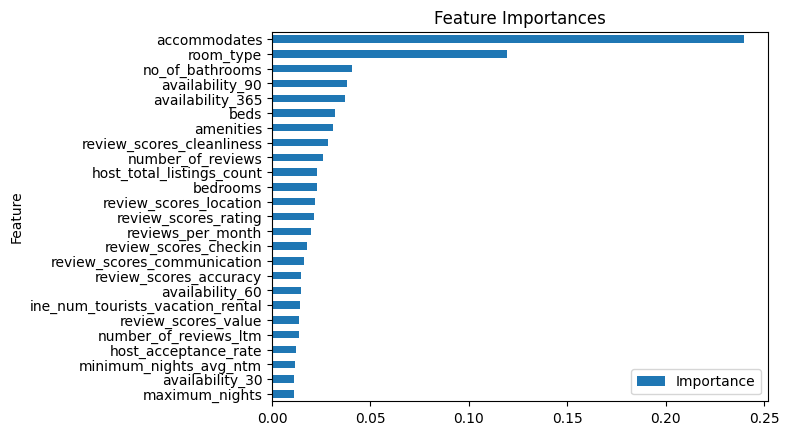

In [8]:
sorted_importances = feat_imp[:25].sort_values(by="Importance", ascending=True)
ax = sorted_importances.plot.barh(x="Feature", y="Importance")
ax.set_title("Feature Importances")
plt.show()

In [9]:
list(feat_imp[:25]["Feature"].unique())

['accommodates',
 'room_type',
 'no_of_bathrooms',
 'availability_90',
 'availability_365',
 'beds',
 'amenities',
 'review_scores_cleanliness',
 'number_of_reviews',
 'host_total_listings_count',
 'bedrooms',
 'review_scores_location',
 'review_scores_rating',
 'reviews_per_month',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_accuracy',
 'availability_60',
 'ine_num_tourists_vacation_rental',
 'review_scores_value',
 'number_of_reviews_ltm',
 'host_acceptance_rate',
 'minimum_nights_avg_ntm',
 'availability_30',
 'maximum_nights']

In [10]:
small_data_5[["id"] + list(feat_imp[:25]["Feature"].unique()) + ["price"]]

,id,accommodates,room_type,no_of_bathrooms,availability_90,availability_365,beds,amenities,review_scores_cleanliness,number_of_reviews,...,review_scores_accuracy,availability_60,ine_num_tourists_vacation_rental,review_scores_value,number_of_reviews_ltm,host_acceptance_rate,minimum_nights_avg_ntm,availability_30,maximum_nights,price
0,18674,8,3.0,2.0,30,264,6.0,24,4.63,33,...,4.41,15,63894,4.28,11,0.94,3.2,5,1125,129.0
1,124342,2,1.0,1.0,47,317,1.0,22,4.61,79,...,4.14,17,63894,4.49,10,0.43,3.0,9,365,60.0
2,128463,2,1.0,1.0,38,294,1.0,41,4.94,347,...,4.91,23,63894,4.82,45,1.00,3.0,8,1125,60.0
3,130227,2,1.0,2.0,30,204,1.0,51,4.92,130,...,4.84,0,63894,4.64,23,1.00,31.0,0,31,80.0
4,135513,5,3.0,1.5,90,365,3.0,37,4.68,131,...,4.74,60,63894,4.56,0,0.18,90.0,30,365,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,3675253,2,3.0,1.0,70,233,1.0,30,4.57,285,...,4.70,46,89325,4.57,54,0.86,2.0,19,1125,75.0
800,3684986,4,3.0,2.0,52,187,3.0,40,4.56,359,...,4.66,31,89325,4.61,61,0.86,2.0,10,1125,102.0
801,3719698,6,3.0,1.5,0,0,4.0,11,4.83,6,...,4.83,0,89325,4.83,0,0.95,3.0,0,1125,95.0
802,3736295,6,3.0,1.0,89,364,4.0,24,4.64,45,...,4.62,59,89325,4.58,26,0.86,2.0,29,1125,141.0


In [11]:
bm.train_random_forest(X=small_data_5[["id"] + list(feat_imp[:25]["Feature"].unique()) + ["price"]].iloc[:, 1:-1], 
                       y=small_data_5[["id"] + list(feat_imp[:25]["Feature"].unique()) + ["price"]]["price"], random_state=42, 
                       path1="../data/output_optimization/small/baseline_feature_importance_redcols.csv",
                       path2="../data/output_optimization/small/metrics_2.csv")

c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', RandomForestRegressor(random_state=42))]),
                 Model          MSE       RMSE        MAE       MAPE        R2
 0   RandomForest_Test  1308.488288  36.173033  26.371863  29.434466  0.452352
 1  RandomForest_Train   176.932597  13.301601   9.761851  12.012618  0.934323)

Comentario:
- El MAE y el RMSE han empeorado.

## 3) Optimización - Quitar columnas que tienen media-alta correlación

Las columnas relacionadas con capacidad de alojamientos

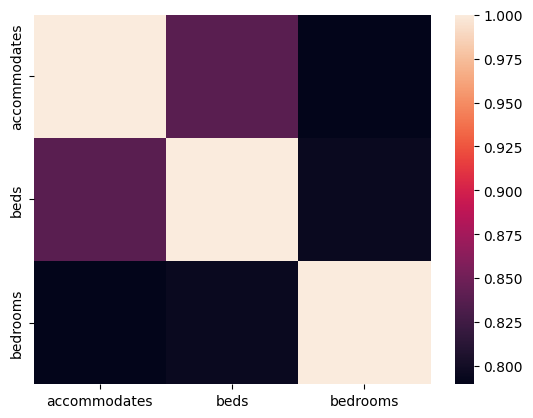

In [12]:
sns.heatmap(small_data_5[["accommodates", "beds", "bedrooms"]].corr());

Comentario:
- Hay alta correlación entre estas tres columnas que no es bueno para el modelo. Como la columna "accomodates" tiene más importancia, así quitaré las otras dos columnas.

In [13]:
small_data_5_opt = small_data_5.copy()
small_data_5_opt = small_data_5_opt.drop(["beds", "bedrooms"], axis=1)

Las columnas relacionadas con disponibilidad de alojamientos

In [14]:
feat_imp[feat_imp["Feature"].str.contains("availability")]

,Feature,Importance
3,availability_90,0.038128
4,availability_365,0.037123
17,availability_60,0.014686
23,availability_30,0.011407
58,has_availability,0.000000


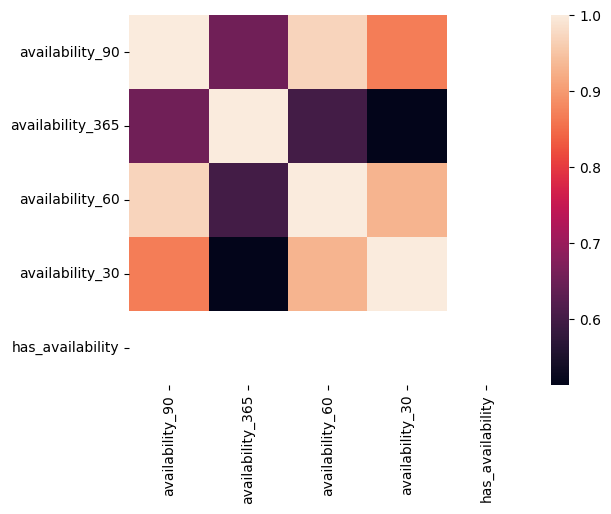

In [15]:
sns.heatmap(small_data_5[["availability_90", "availability_365", "availability_60", "availability_30", "has_availability"]].corr());

Comentario:
- Como la columna "availability_90" es la más importante y la columna "has_availability" no tiene correlación alta con las otras columnas, así quitaré el resto.

In [16]:
small_data_5_opt = small_data_5_opt.drop(["availability_365", "availability_60", "availability_30"], axis=1)

Las columnas relacionadas con reseñas

In [17]:
feat_imp[feat_imp["Feature"].str.contains("review")]

,Feature,Importance
7,review_scores_cleanliness,0.028449
8,number_of_reviews,0.025770
11,review_scores_location,0.021884
12,review_scores_rating,0.021201
13,reviews_per_month,0.019996
14,review_scores_checkin,0.017939
15,review_scores_communication,0.016416
16,review_scores_accuracy,0.014788
19,review_scores_value,0.013796
20,number_of_reviews_ltm,0.013768


In [18]:
feat_imp[feat_imp["Feature"].str.contains("review")]["Feature"].values

array(['review_scores_cleanliness', 'number_of_reviews',
       'review_scores_location', 'review_scores_rating',
       'reviews_per_month', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_accuracy',
       'review_scores_value', 'number_of_reviews_ltm', 'last_review',
       'first_review', 'number_of_reviews_l30d'], dtype=object)

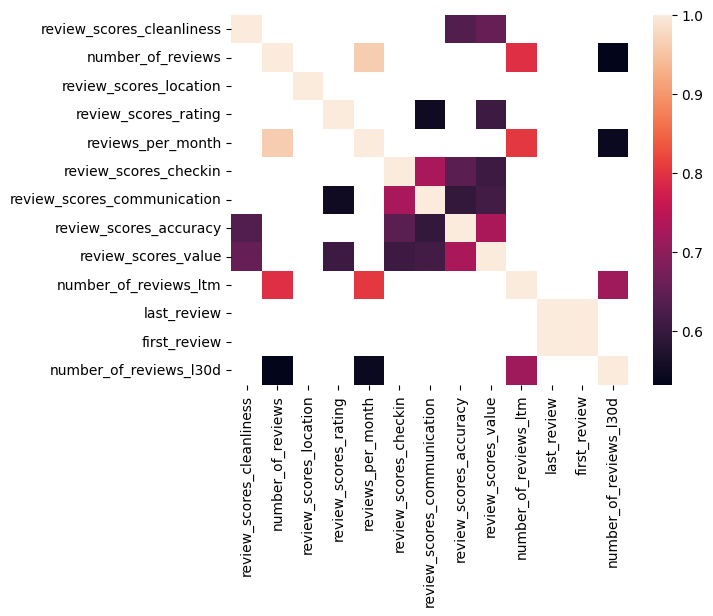

In [19]:
sys.path.insert(0, '../functions')
import find_correlation as fc


sns.heatmap(fc.func(small_data_5[['review_scores_cleanliness', 'number_of_reviews',
       'review_scores_location', 'review_scores_rating',
       'reviews_per_month', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_accuracy',
       'review_scores_value', 'number_of_reviews_ltm', 'last_review',
       'first_review', 'number_of_reviews_l30d']].corr(), value=0.5, correlation="both"));

Comentario:
- Las columnas relacionadas con reseñas, hay correlación entre muchas columnas. Voy a quitar: 
	- review_scores_accuracy
	- review_scores_value
	- reviews_per_month
	- number_of_reviews_ltm
	- review_scores_communication
	- review_scores_value
	- number_of_reviews_l30d
	- first_review

In [20]:
small_data_5_opt = small_data_5_opt.drop(["review_scores_accuracy", "review_scores_value", "reviews_per_month", "number_of_reviews_ltm",
                                          "review_scores_communication", "review_scores_value", "number_of_reviews_l30d", "first_review"], 
                                          axis=1)

Las columnas relacionadas con mínimo o máximo de noche de estancia

In [21]:
feat_imp[feat_imp["Feature"].str.contains("night")]

,Feature,Importance
22,minimum_nights_avg_ntm,0.011653
24,maximum_nights,0.011047
27,minimum_minimum_nights,0.008939
28,minimum_nights,0.008693
29,maximum_minimum_nights,0.008513
31,minimum_maximum_nights,0.007300
38,maximum_nights_avg_ntm,0.004826
41,maximum_maximum_nights,0.003955


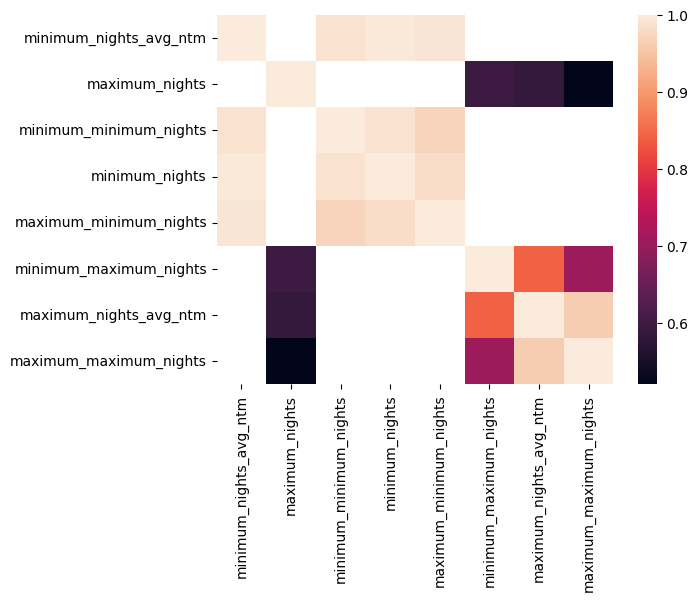

In [22]:
sns.heatmap(fc.func(small_data_5[["minimum_nights_avg_ntm", "maximum_nights", "minimum_minimum_nights", "minimum_nights",
                                  "maximum_minimum_nights", "minimum_maximum_nights", "maximum_nights_avg_ntm", 
                                  "maximum_maximum_nights"]].corr(), value=0.5, correlation="both"));

Comentario:
- En esta matriz de correlación, voy a quitar las columnas:
	- minimum_minimum_nights
	- minimum_nights
	- maximum_minimum_nights
	- minimum_maximum_nights
	- maximum_nights_avg_ntm
	- maximum_maximum_nights

In [23]:
small_data_5_opt = small_data_5_opt.drop(["minimum_minimum_nights", "minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights",
                                          "maximum_nights_avg_ntm", "maximum_maximum_nights"], 
                                          axis=1)

In [24]:
small_data_5_opt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            804 non-null    int64  
 1   host_acceptance_rate                          804 non-null    float64
 2   host_verifications                            804 non-null    int64  
 3   availability_90                               804 non-null    int64  
 4   ine_percent_vacation_rental                   804 non-null    float64
 5   host_total_listings_count                     804 non-null    int64  
 6   review_scores_cleanliness                     804 non-null    float64
 7   calculated_host_listings_count_shared_rooms   804 non-null    int64  
 8   host_listings_count                           804 non-null    int64  
 9   review_scores_location                        804 non-null    flo

In [25]:
bm.train_random_forest(X=small_data_5_opt.iloc[:, 1:-1], y=small_data_5_opt["price"], random_state=42, 
                       path1="../data/output_optimization/small/baseline_feature_importance_redcols_2.csv",
                       path2="../data/output_optimization/small/metrics_3.csv")

c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', RandomForestRegressor(random_state=42))]),
                 Model          MSE       RMSE        MAE       MAPE        R2
 0   RandomForest_Test  1276.557441  35.728944  25.896273  29.063558  0.465717
 1  RandomForest_Train   174.362540  13.204641   9.565101  11.732345  0.935277)

Comentario:
- El MAE y el RMSE no mejoran

## 4) Optimización - Aplicar el feature importance otra vez en base al apartado 3

Mira la suma cumulativa de importancia y aplica el feature importance de las columnas reducidas del apartado 3

In [26]:
feat_imp_redcols_2 = pd.read_csv("../data/output_optimization/small/baseline_feature_importance_redcols_2.csv")
feat_imp_redcols_2 = feat_imp_redcols_2.drop("Unnamed: 0", axis=1)

In [27]:
feat_imp_redcols_2.cumsum()

,Feature,Importance
0,accommodates,0.251179
1,accommodatesroom_type,0.379739
2,accommodatesroom_typeavailability_90,0.455582
3,accommodatesroom_typeavailability_90no_of_bath...,0.516573
4,accommodatesroom_typeavailability_90no_of_bath...,0.569573
5,accommodatesroom_typeavailability_90no_of_bath...,0.610111
6,accommodatesroom_typeavailability_90no_of_bath...,0.648473
7,accommodatesroom_typeavailability_90no_of_bath...,0.681435
8,accommodatesroom_typeavailability_90no_of_bath...,0.713702
9,accommodatesroom_typeavailability_90no_of_bath...,0.744745


Las 15 primeras columnas tienen una suma cumulativa de importancia de un 0.863122. Voy a quitar el resto de las columnas.

In [28]:
feat_imp_redcols_2[:15].cumsum()

,Feature,Importance
0,accommodates,0.251179
1,accommodatesroom_type,0.379739
2,accommodatesroom_typeavailability_90,0.455582
3,accommodatesroom_typeavailability_90no_of_bath...,0.516573
4,accommodatesroom_typeavailability_90no_of_bath...,0.569573
5,accommodatesroom_typeavailability_90no_of_bath...,0.610111
6,accommodatesroom_typeavailability_90no_of_bath...,0.648473
7,accommodatesroom_typeavailability_90no_of_bath...,0.681435
8,accommodatesroom_typeavailability_90no_of_bath...,0.713702
9,accommodatesroom_typeavailability_90no_of_bath...,0.744745


In [29]:
feat_imp_redcols_2[:15]

,Feature,Importance
0,accommodates,0.251179
1,room_type,0.128561
2,availability_90,0.075842
3,no_of_bathrooms,0.060992
4,number_of_reviews,0.053000
5,amenities,0.040538
6,review_scores_cleanliness,0.038363
7,review_scores_rating,0.032962
8,minimum_nights_avg_ntm,0.032267
9,review_scores_location,0.031042


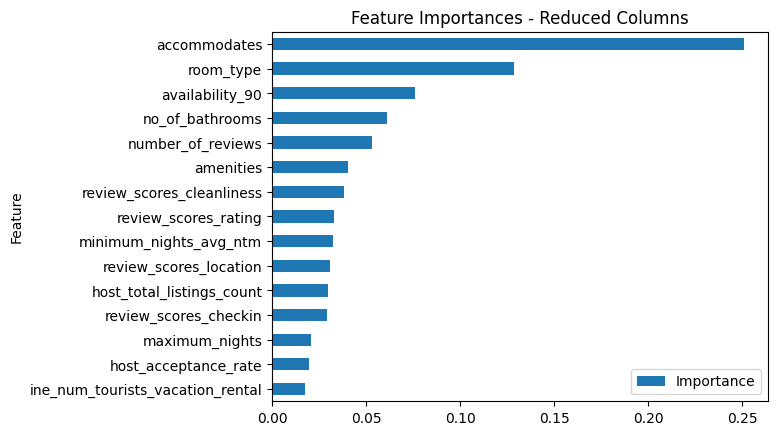

In [30]:
# Las primeras 15 columnas tienen una suma cumulativa de importancia de 0.861772
sorted_importances = feat_imp_redcols_2[:15].sort_values(by="Importance", ascending=True)
ax = sorted_importances.plot.barh(x="Feature", y="Importance")
ax.set_title("Feature Importances - Reduced Columns")
plt.show()

Vamos a entrenar otra vez el modelo con solamente 15 columnas más importantes

In [31]:
imp_cols = ["id"] + list(feat_imp_redcols_2[:15]["Feature"].unique()) + ["price"]
imp_cols

['id',
 'accommodates',
 'room_type',
 'availability_90',
 'no_of_bathrooms',
 'number_of_reviews',
 'amenities',
 'review_scores_cleanliness',
 'review_scores_rating',
 'minimum_nights_avg_ntm',
 'review_scores_location',
 'host_total_listings_count',
 'review_scores_checkin',
 'maximum_nights',
 'host_acceptance_rate',
 'ine_num_tourists_vacation_rental',
 'price']

In [32]:
small_data_5[imp_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                804 non-null    int64  
 1   accommodates                      804 non-null    int64  
 2   room_type                         804 non-null    float64
 3   availability_90                   804 non-null    int64  
 4   no_of_bathrooms                   804 non-null    float64
 5   number_of_reviews                 804 non-null    int64  
 6   amenities                         804 non-null    int64  
 7   review_scores_cleanliness         804 non-null    float64
 8   review_scores_rating              804 non-null    float64
 9   minimum_nights_avg_ntm            804 non-null    float64
 10  review_scores_location            804 non-null    float64
 11  host_total_listings_count         804 non-null    int64  
 12  review_s

In [33]:
bm.train_random_forest(X=small_data_5[imp_cols].iloc[:, 1:-1], y=small_data_5[imp_cols]["price"], random_state=42, 
                       path1="../data/output_optimization/small/baseline_feature_importance_redcols_3.csv",
                       path2="../data/output_optimization/small/metrics_4.csv")

c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
c:\Users\Selvie\OneDrive\SELVIE\Lifelong Learning\The Bridge - Data Science Bootcamp\MyCode\3-Machine_Learning\Entrega\Proyecto ML\Airbnb\notebooks\../functions\run_baseline_model.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', RandomForestRegressor(random_state=42))]),
                 Model          MSE       RMSE        MAE       MAPE        R2
 0   RandomForest_Test  1317.131334  36.292304  26.029689  28.772216  0.448735
 1  RandomForest_Train   174.072154  13.193641   9.574743  11.748483  0.935385)

Comentario:
- El MAE y el RMSE no mejoran

#### Feature Importance (antes y después de reducir columnas que tenían bastante correlación entre ellas)

In [34]:
print(len(feat_imp))
print(len(feat_imp_redcols_2))

59
41


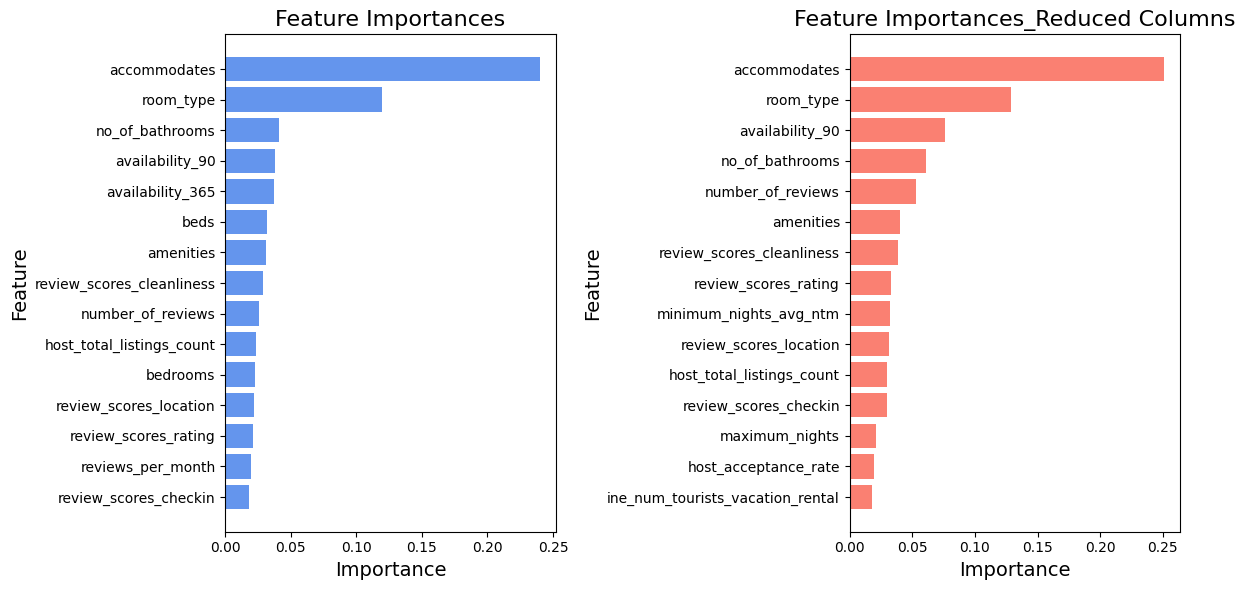

In [35]:
sorted_importances = feat_imp[:15].sort_values(by="Importance", ascending=True)
sorted_importances_redcols = feat_imp_redcols_2[:15].sort_values(by="Importance", ascending=True)

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
axs[0].barh(sorted_importances["Feature"], sorted_importances["Importance"], color="cornflowerblue")
axs[0].set_title("Feature Importances", fontsize=16)
axs[0].set_xlabel("Importance", fontsize=14)
axs[0].set_ylabel("Feature", fontsize=14)

axs[1].barh(sorted_importances_redcols["Feature"], sorted_importances_redcols["Importance"], color="salmon")
axs[1].set_title("Feature Importances_Reduced Columns", fontsize=16)
axs[1].set_xlabel("Importance", fontsize=14)
axs[1].set_ylabel("Feature", fontsize=14)

plt.tight_layout()
plt.show()


## 5) Optimización del Random Forest con PCA

In [36]:
X = small_data_5.iloc[:, 1:-1]
y = small_data_5["price"]

# Split the data into train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.20,
                                                                    random_state=42)

# Standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [37]:
pca.explained_variance_ratio_.cumsum()

array([0.11127675, 0.20754547, 0.27815813, 0.34508371, 0.406858  ,
       0.46624394, 0.51815865, 0.56560325, 0.60372295, 0.63859755,
       0.66984912, 0.6965688 , 0.72141042, 0.74579991, 0.7668327 ,
       0.78560978, 0.80292303, 0.81921063, 0.83447244, 0.84907584])

In [38]:
# Create a RandomForestRegressor
rf_gs = RandomForestRegressor(random_state=42, 
                           max_depth=20, 
                           min_samples_leaf=1, 
                           min_samples_split=2, 
                           n_estimators=250)

# Train the data
rf_gs.fit(X_train_pca, y_train)

# Predict on X_test_pca data
y_pred_test = rf_gs.predict(X_test_pca)

# Get the metrics for test data
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)


# Predict on train set
y_pred_train = rf_gs.predict(X_train_pca)

# Get the metrics for train data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
r2_train = r2_score(y_train, y_pred_train)

# Add the metrics to the metrics_df dataframe
metrics_test = ["RandomForest_GS_PCA_Test", mse_test, rmse_test, mae_test, mape_test, r2_test]
metrics_train = ["RandomForest_GS_PCA_Train", mse_train, rmse_train, mae_train, mape_train, r2_train]
metrics_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "MAE", "MAPE", "R2"])
metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)
metrics_df.to_csv("../data/output_optimization/small/metrics_5.csv")
metrics_df

C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\22856635.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\22856635.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


,Model,MSE,RMSE,MAE,MAPE,R2
0,RandomForest_GS_PCA_Test,1449.521193,38.072578,28.558354,0.334129,0.393325
1,RandomForest_GS_PCA_Train,188.339044,13.723667,10.371796,13.394045,0.930089


Comentario:
- Las métricas han empeorado utilizando PCA

## 6) Optimización - Aplicar la transformación logarítmica en el target (price)

C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\3165730671.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(small_data_5["price"]);


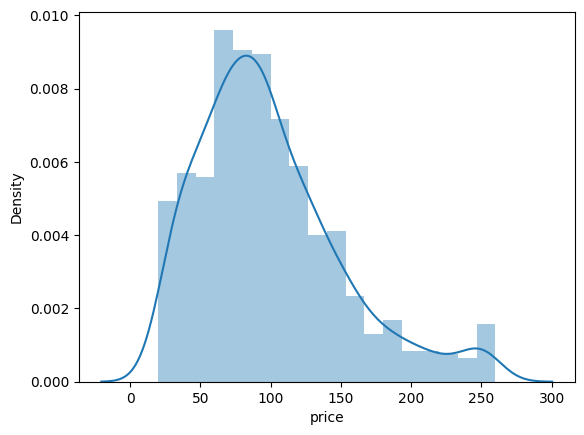

In [39]:
sns.distplot(small_data_5["price"]);

In [40]:
# Log-transform the target variable
log_price = np.log(small_data_5["price"])
small_data_5_log = small_data_5.copy()
small_data_5_log["log_price"] = log_price
small_data_5_log = small_data_5_log.drop("price", axis=1)

# Split the data into train and test sets
X = small_data_5_log.iloc[:, 1:-1]
y = small_data_5_log["log_price"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Regressor model with specified hyperparameters
rf_log = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=250)
rf_log.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = rf_log.predict(X_test)

# Convert the y_pred_test and the y_test back to the original scale by taking the exponent
y_pred_test = np.exp(y_pred_test)
y_test = np.exp(y_test)

# Calculate evaluation metrics (MSE, RMSE, MAE, MAPE, R2) on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
r2_test = r2_score(y_test, y_pred_test)


# Make predictions on the train set
y_pred_train = rf_log.predict(X_train)

# Convert the y_pred_train and the y_train back back to the original scale by taking the exponent
y_pred_train = np.exp(y_pred_train)
y_train = np.exp(y_train)

# Calculate evaluation metrics (MSE, RMSE, MAE, MAPE, R2) on the train set
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
r2_train = r2_score(y_train, y_pred_train)

# Add the metrics to the metrics_df dataframe
metrics_test = ["RandomForest_GS_Log_Test", mse_test, rmse_test, mae_test, mape_test, r2_test]
metrics_train = ["RandomForest_GS_Log_Train", mse_train, rmse_train, mae_train, mape_train, r2_train]
metrics_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "MAE", "MAPE", "R2"])
metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)
metrics_df.to_csv("../data/output_optimization/small/metrics_6.csv")
metrics_df

C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\2563385135.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\2563385135.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


,Model,MSE,RMSE,MAE,MAPE,R2
0,RandomForest_GS_Log_Test,1315.294986,36.266996,25.233492,25.505758,0.449504
1,RandomForest_GS_Log_Train,231.287303,15.208133,9.895067,9.933812,0.914147


Comentario:
- Las métricas (MAE y RMSE) han mejorado, aunque no es una mejora significativa

## 7) Optimización - Aplicar la transformación logarítmica en el target (price) y ejecuta con el dataset de columnas reducidas (15 features más importantes)

In [41]:
imp_cols

['id',
 'accommodates',
 'room_type',
 'availability_90',
 'no_of_bathrooms',
 'number_of_reviews',
 'amenities',
 'review_scores_cleanliness',
 'review_scores_rating',
 'minimum_nights_avg_ntm',
 'review_scores_location',
 'host_total_listings_count',
 'review_scores_checkin',
 'maximum_nights',
 'host_acceptance_rate',
 'ine_num_tourists_vacation_rental',
 'price']

In [42]:
# Log-transform the target variable
log_price = np.log(small_data_5["price"])
small_data_5_log = small_data_5.copy()
small_data_5_log = small_data_5_log[imp_cols]
small_data_5_log["log_price"] = log_price
small_data_5_log = small_data_5_log.drop("price", axis=1)

# Split the data into train and test sets
X = small_data_5_log.iloc[:, 1:-1]
y = small_data_5_log["log_price"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Regressor model with specified hyperparameters
rf_log = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=250)
rf_log.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = rf_log.predict(X_test)

# Convert the y_pred_test and the y_test back to the original scale by taking the exponent
y_pred_test = np.exp(y_pred_test)
y_test = np.exp(y_test)

# Calculate evaluation metrics (MSE, RMSE, MAE, MAPE, R2) on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
r2_test = r2_score(y_test, y_pred_test)


# Make predictions on the train set
y_pred_train = rf_log.predict(X_train)

# Convert the y_pred_train and the y_train back back to the original scale by taking the exponent
y_pred_train = np.exp(y_pred_train)
y_train = np.exp(y_train)

# Calculate evaluation metrics (MSE, RMSE, MAE, MAPE, R2) on the train set
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
r2_train = r2_score(y_train, y_pred_train)

# Add the metrics to the metrics_df dataframe
metrics_test = ["RandomForest_GS_Log_Test", mse_test, rmse_test, mae_test, mape_test, r2_test]
metrics_train = ["RandomForest_GS_Log_Train", mse_train, rmse_train, mae_train, mape_train, r2_train]
metrics_df = pd.DataFrame(columns=["Model", "MSE", "RMSE", "MAE", "MAPE", "R2"])
metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)
metrics_df.to_csv("../data/output_optimization/small/metrics_7.csv")
metrics_df

C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\1790871185.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_test, index=metrics_df.columns), ignore_index=True)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\1790871185.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(pd.Series(metrics_train, index=metrics_df.columns), ignore_index=True)


,Model,MSE,RMSE,MAE,MAPE,R2
0,RandomForest_GS_Log_Test,1373.711784,37.063618,25.561046,25.641569,0.425054
1,RandomForest_GS_Log_Train,235.521329,15.346704,9.968942,10.001590,0.912575


## RESUMEN

Abre las métricas del modelo base

In [43]:
res_small_5 = pd.read_csv("../data/output_data_5/metrics_small_data_no_outliers_cols_3.csv")
res_small_5[res_small_5["MAE"] == (res_small_5["MAE"].min())]

,Model,MSE,RMSE,MAE,MAPE,R2
0,RandomForest,1237.557138,35.17893,25.709565,0.290405,0.48204


Juntar las métricas de todas las pruebas de optimización

Para referencia, esta es el número de pruebas de optimización
1) Optimización del RandomForest con el Grid Search
2) Optimización del RandomForest con el Feature Importance
3) Optimización - Quitar columnas que tienen media-alta correlación
4) Optimización - Aplicar el feature importance otra vez en base al apartado 3
5) Optimización del Random Forest con PCA
6) Optimización - Aplicar la transformación logarítmica en el target (price)
7) Optimización - Aplicar la transformación logarítmica en el target (price) y ejecuta con el dataset de columnas reducidas (15 features más importantes)

In [103]:
# Create an empty DataFrame to store all the metrics
all_metrics_df = pd.DataFrame()

# Loop through all the CSV files with the specified format names
for filename in glob.glob("../data/output_optimization/small/metrics_*.csv"):
    # Read in the CSV file as a DataFrame
    metrics_df = pd.read_csv(filename, index_col=0)
    
    # Append the metrics to the all_metrics_df DataFrame
    all_metrics_df = all_metrics_df.append(metrics_df)

# # Add the number of optimization experiment
# all_metrics_df["Optimization_No"] = [i for i in range(1, 7) for _ in range(2)]

all_metrics_df["Optimization"] = ["Grid Search", "Grid Search",
                                  "Feature Importance", "Feature Importance",
                                  "Drop Med-High Corr Columns", "Drop Med-High Corr Columns",
                                  "Corr_Feature Importance", "Corr_Feature Importance",
                                  "PCA", "PCA",
                                  "Log Transformation", "Log Transformation",
                                  "Log Transform_Feat. Imp.", "Log Transform_Feat. Imp."]

# Print the concatenated DataFrame
all_metrics_df

C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\3981186287.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_metrics_df = all_metrics_df.append(metrics_df)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\3981186287.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_metrics_df = all_metrics_df.append(metrics_df)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\3981186287.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_metrics_df = all_metrics_df.append(metrics_df)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\3981186287.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_metrics_df = all_metrics_df

,Model,MSE,RMSE,MAE,MAPE,R2,Optimization
0,RandomForest_Test,1229.402006,35.062829,25.444070,28.499282,0.485453,Grid Search
1,RandomForest_Train,174.937682,13.226401,9.549586,11.553094,0.935064,Grid Search
0,RandomForest_Test,1308.488288,36.173033,26.371863,29.434466,0.452352,Feature Importance
1,RandomForest_Train,176.932597,13.301601,9.761851,12.012618,0.934323,Feature Importance
0,RandomForest_Test,1276.557441,35.728944,25.896273,29.063558,0.465717,Drop Med-High Corr Columns
1,RandomForest_Train,174.362540,13.204641,9.565101,11.732345,0.935277,Drop Med-High Corr Columns
0,RandomForest_Test,1317.131334,36.292304,26.029689,28.772216,0.448735,Corr_Feature Importance
1,RandomForest_Train,174.072154,13.193641,9.574743,11.748483,0.935385,Corr_Feature Importance
0,RandomForest_GS_PCA_Test,1449.521193,38.072578,28.558354,0.334129,0.393325,PCA
1,RandomForest_GS_PCA_Train,188.339044,13.723667,10.371796,13.394045,0.930089,PCA


Divide las métricas entre test y train y compáralas

In [104]:
test_metrics = all_metrics_df[all_metrics_df["Model"].str.contains("Test")]
test_metrics[test_metrics["MAE"] == test_metrics["MAE"].min()]

,Model,MSE,RMSE,MAE,MAPE,R2,Optimization
0,RandomForest_GS_Log_Test,1315.294986,36.266996,25.233492,25.505758,0.449504,Log Transformation


In [123]:
test_metrics.columns

Index(['Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Optimization'], dtype='object')

In [126]:
# test_metrics = test_metrics.sort_values(by=["MAE"])
test_metrics = test_metrics[['Model', 'Optimization', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']]
test_metrics

,Model,Optimization,MSE,RMSE,MAE,MAPE,R2
0,RandomForest_Test,Grid Search,1229.402006,35.062829,25.444070,28.499282,0.485453
0,RandomForest_Test,Feature Importance,1308.488288,36.173033,26.371863,29.434466,0.452352
0,RandomForest_Test,Drop Med-High Corr Columns,1276.557441,35.728944,25.896273,29.063558,0.465717
0,RandomForest_Test,Corr_Feature Importance,1317.131334,36.292304,26.029689,28.772216,0.448735
0,RandomForest_GS_PCA_Test,PCA,1449.521193,38.072578,28.558354,0.334129,0.393325
0,RandomForest_GS_Log_Test,Log Transformation,1315.294986,36.266996,25.233492,25.505758,0.449504
0,RandomForest_GS_Log_Test,Log Transform_Feat. Imp.,1373.711784,37.063618,25.561046,25.641569,0.425054


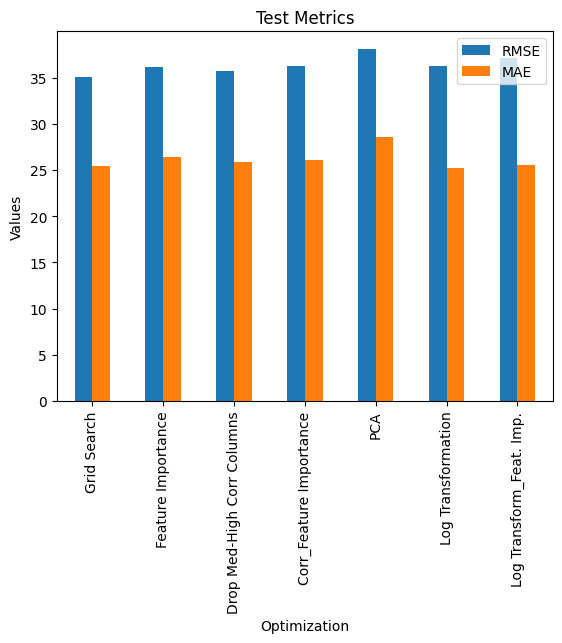

In [122]:
test_metrics[["Optimization", "RMSE", "MAE"]].plot(kind="bar", x="Optimization")
plt.xlabel('Optimization')
plt.ylabel('Values')
plt.title('Test Metrics')
plt.show()

In [125]:
train_metrics = all_metrics_df[all_metrics_df["Model"].str.contains("Train")]
train_metrics[train_metrics["MAE"] == train_metrics["MAE"].min()]

,Model,MSE,RMSE,MAE,MAPE,R2,Optimization
1,RandomForest_Train,174.937682,13.226401,9.549586,11.553094,0.935064,Grid Search


In [127]:
# train_metrics = train_metrics.sort_values(by=["MAE"])
train_metrics = train_metrics[['Model', 'Optimization', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']]
train_metrics

,Model,Optimization,MSE,RMSE,MAE,MAPE,R2
1,RandomForest_Train,Grid Search,174.937682,13.226401,9.549586,11.553094,0.935064
1,RandomForest_Train,Feature Importance,176.932597,13.301601,9.761851,12.012618,0.934323
1,RandomForest_Train,Drop Med-High Corr Columns,174.362540,13.204641,9.565101,11.732345,0.935277
1,RandomForest_Train,Corr_Feature Importance,174.072154,13.193641,9.574743,11.748483,0.935385
1,RandomForest_GS_PCA_Train,PCA,188.339044,13.723667,10.371796,13.394045,0.930089
1,RandomForest_GS_Log_Train,Log Transformation,231.287303,15.208133,9.895067,9.933812,0.914147
1,RandomForest_GS_Log_Train,Log Transform_Feat. Imp.,235.521329,15.346704,9.968942,10.001590,0.912575


Compare train vs test

In [129]:
train_test_comp = pd.merge(train_metrics[["Optimization", "MAE", "MAPE", "RMSE", "R2"]], test_metrics[["Optimization", "MAE", "MAPE", "RMSE", "R2"]], 
                           on="Optimization", how="left")
train_test_comp = train_test_comp.rename({"MAE_x": "MAE_Train",
                                          "MAE_y": "MAE_Test",
                                          "MAPE_x": "MAPE_Train",
                                          "MAPE_y": "MAPE_Test",
                                          "RMSE_x": "RMSE_Train",
                                          "RMSE_y": "RMSE_Test",
                                          "R2_x": "R2_Train",
                                          "R2_y": "R2_Test"}, axis=1)
train_test_comp = train_test_comp[["Optimization", "MAE_Test", "MAE_Train", "MAPE_Test", "MAPE_Train", "RMSE_Test", "RMSE_Train",
                                   "R2_Test", "R2_Train"]]
# train_test_comp = train_test_comp.sort_values(by="MAE_Test").reset_index().drop("index", axis=1)
train_test_comp

,Optimization,MAE_Test,MAE_Train,MAPE_Test,MAPE_Train,RMSE_Test,RMSE_Train,R2_Test,R2_Train
0,Grid Search,25.444070,9.549586,28.499282,11.553094,35.062829,13.226401,0.485453,0.935064
1,Feature Importance,26.371863,9.761851,29.434466,12.012618,36.173033,13.301601,0.452352,0.934323
2,Drop Med-High Corr Columns,25.896273,9.565101,29.063558,11.732345,35.728944,13.204641,0.465717,0.935277
3,Corr_Feature Importance,26.029689,9.574743,28.772216,11.748483,36.292304,13.193641,0.448735,0.935385
4,PCA,28.558354,10.371796,0.334129,13.394045,38.072578,13.723667,0.393325,0.930089
5,Log Transformation,25.233492,9.895067,25.505758,9.933812,36.266996,15.208133,0.449504,0.914147
6,Log Transform_Feat. Imp.,25.561046,9.968942,25.641569,10.001590,37.063618,15.346704,0.425054,0.912575


Guarda el mejor modelo

In [130]:
# Save the model using pickle
with open("small_best_model.pkl", "wb") as f:
    pickle.dump(rf_log, f)

## Análisis

### Modelos

Desde el punto de vista técnica:
- Después de hacer varias pruebas para optimizar el modelo base, el mejor MAE en test se conseguió cuando:
	- le apliqué la transformación logarítmica al target (price)
	- utilicé el baseline model (Random Forest Regressor) con los mejores hipérparámetros de Grid Search
<br><br>
- El mejor MAE después de optimizar es 25.23 que es una cifra un poco mejor del MAE del modelo base (MAE: 25.71). Mientras el RMSE de este modelo optimizado es 36.27 con lo cual es un poco más alto que él del modelo base (RMSE: 35.18). Se ve que no se aprecia la diferencia entre antes y después de optimizar el modelo base.
<br><br>
- Hay overfitting porque me salió un error más grande en test que en el train, pero no se puede bajar más el error después de varias pruebas distintas. He mirado un trabajo similar de otra gente en este [link](https://github.com/yoojin-kathleen/airbnb-price/blob/main/Team_11_Airbnb.ipynb) que hizo una predicción en el caso de Airbnb EE.UU y obtuvieron un MAE de 50-58 (depende del modelo) sobre el precio promedio de 184 que es más o menos igual que las métricas he obtenido. Si tuviese más datos con más features, quizás podría obtener mejores métricas.
<br><br>
- Después de reducir las columnas menos significativas, hay 15 features que contibuyen un 86% (suma cumulativa) al rendimiento del modelo. Sin embargo, entrenando con sólo esos 15 features no mejora el MAE y el RMSE.

Desde el punto de vista de negocio:
- Hay un margen de error de 25 EUR approximadamente lo que sigfinifica que el precio de alquiler puede ser 25 EUR más o 25 EUR menos del precio real. Por ejemplo, si cogemos el precio promedio de 99 EUR/noche, el margen será entre 75 y 125 EUR/noche. El número promedio de dormitorios es 2, así que, sería entre 38 EUR/noche/dormitorio y 63 EUR/noche/dormitorio, lo que coincide con lo que dice Airbnb en su [página web](https://www.airbnb.es/host/homes?room_type=PRIVATE_ROOM&adults=2).

Recomendación:
- Si un propietario quiere alquilar su alojamiento a corto plazo, se aconsejaría utilizar el límite superior del precio que es un 124 EUR/noche (para un alojamiento de 2 dormitorios). Así, con la tasa aproximada de ocupación de un 80% (suponiendo que es un alquiler de verano de 3 meses), podría ganar aprox. 9.000 EUR/año bruto.
- Si un propietario quiere alquilar su alojamiento a largo plazo,  se aconsejaría utilizar el límite inferior del precio que es un 74 EUR/noche (para un alojamiento de 2 dormitorios). Así, con la tasa aproximada de ocupación de un 60%, podría ganar aprox. 16.200 EUR/año bruto. Se puede consultar al cálculo de abajo para más detalle.

### Cálculo del precio de alquiler de Aibrnb

In [89]:
occupancy_rate = [("Jan", 0.5),
                  ("Feb", 0.5),
                  ("Mar", 0.5),
                  ("Apr", 0.5),
                  ("May", 0.5),
                  ("Jun", 0.8),
                  ("Jul", 0.8),
                  ("Aug", 0.8),
                  ("Sep", 0.5),
                  ("Oct", 0.5),
                  ("Nov", 0.5),
                  ("Dec", 0.5)]

occupancy_rate_df = pd.DataFrame(occupancy_rate, columns=["Month", "Occupancy Rate"])
occupancy_rate_df

,Month,Occupancy Rate
0,Jan,0.5
1,Feb,0.5
2,Mar,0.5
3,Apr,0.5
4,May,0.5
5,Jun,0.8
6,Jul,0.8
7,Aug,0.8
8,Sep,0.5
9,Oct,0.5


In [94]:
summer = ("Jun", "Jul", "Aug")

occup_rate_short = round(occupancy_rate_df[occupancy_rate_df["Month"].isin(summer)]["Occupancy Rate"].mean(), 1)
print("Tasa de ocupación-corto plazo:", occup_rate_short)
occup_rate_long = round(occupancy_rate_df["Occupancy Rate"].mean(), 1)
print("Tasa de ocupación-largo plazo:", occup_rate_long, "\n")

avg_price = round(small_data_5["price"].mean(), 0)
print("Precio promedio (EUR/noche):", avg_price)

error_margin = round(test_metrics[test_metrics["MAE"] == test_metrics["MAE"].min()]["MAE"].values[0], 0)
print("Margen de error (EUR/noche):", error_margin)

lower_price_limit = avg_price - error_margin
upper_price_limit = avg_price + error_margin
print("Límite inferior de precio (EUR/noche):", lower_price_limit)
print("Límite superior de precio (EUR/noche):", upper_price_limit)


Tasa de ocupación-corto plazo: 0.8
Tasa de ocupación-largo plazo: 0.6 

Precio promedio (EUR/noche): 99.0
Margen de error (EUR/noche): 25.0
Límite inferior de precio (EUR/noche): 74.0
Límite superior de precio (EUR/noche): 124.0


In [96]:
availability_days = [30, 60, 90, 365]

lower_profit_rental = []
upper_profit_rental = []

for i in availability_days:
    low = round((lower_price_limit * i * occup_rate_long), 0)
    lower_profit_rental.append(low)
    high = round((upper_price_limit * i * occup_rate_short), 0)
    upper_profit_rental.append(high)

print(lower_profit_rental)

print(upper_profit_rental)


[1332.0, 2664.0, 3996.0, 16206.0]
[2976.0, 5952.0, 8928.0, 36208.0]


In [97]:
rental_profit_all = pd.DataFrame(columns=["availability_30", "availability_60", "availability_90",
                                          "availability_365"])
rental_profit_all = rental_profit_all.append(pd.Series(lower_profit_rental, index=rental_profit_all.columns), ignore_index=True)
rental_profit_all = rental_profit_all.append(pd.Series(upper_profit_rental, index=rental_profit_all.columns), ignore_index=True)
rental_profit_all["Price(EUR/night)-2_bedrooms"] = [lower_price_limit, upper_price_limit]
rental_profit_all["Price Limit"] = ["Lower price limit_long term", "Upper price limit_short term"]
rental_profit_all = rental_profit_all[["Price Limit", "Price(EUR/night)-2_bedrooms", "availability_30", "availability_60", "availability_90", 
                                       "availability_365"]]
rental_profit_all

C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\459540907.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rental_profit_all = rental_profit_all.append(pd.Series(lower_profit_rental, index=rental_profit_all.columns), ignore_index=True)
C:\Users\Selvie\AppData\Local\Temp\ipykernel_15804\459540907.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rental_profit_all = rental_profit_all.append(pd.Series(upper_profit_rental, index=rental_profit_all.columns), ignore_index=True)


,Price Limit,Price(EUR/night)-2_bedrooms,availability_30,availability_60,availability_90,availability_365
0,Lower price limit_long term,74.0,1332.0,2664.0,3996.0,16206.0
1,Upper price limit_short term,124.0,2976.0,5952.0,8928.0,36208.0


In [98]:
long_rental_profit = rental_profit_all.loc[0, "availability_365"]
print("Beneficio bruto aprox-largo plazo (EUR/año):", long_rental_profit)

short_rental_profit = rental_profit_all.loc[1, "availability_90"]
print("Beneficio bruto aprox-corto plazo (EUR/año):", short_rental_profit)

Beneficio bruto aprox-largo plazo (EUR/año): 16206.0
Beneficio bruto aprox-corto plazo (EUR/año): 8928.0


### Feature Importances

Los factores que más influyen en el precio (86% de contribución) son:
- capacidad de alojamiento --> Es normal si un alojamiento que tiene más capacidad es más caro que él que tiene menos capacidad. Con referencia a mi proyecto anterior de EDA, los top 200 alojamientos de Airbnb suelen tener 1-2 dormitorios en los que pueden caber hasta 4 personas.
- tipo de alojamiento (habitación compartida, habitación privada, habitación de hotel, casa/piso entero)
- disponibilidad (30, 60, 90, 365) --> los priopietarios de Airbnb tienen flexibilidad de gestionar la disponibilidad de su alojamiento. Sin embargo, hay una regulación de días de disponibilidad. Si un alojamiento tiene una disponibilidad de 30 a 90, sólo puede estar alquilado a corto plazo (30 significa 30 días al año, 90 significa 90 días al año). Una vez que haya alcanzado su límite, Airbnb cerrará automáticamente las reservas de su propiedad hasta el final del año calendario. El límite de 90 días se aplica tanto a 90 días consecutivos como a 90 días repartidos a lo largo del año. Si un propietario quiere alquilar su vivienda a largo plazo (disonibilidad de 365), tiene que sacar una licencia de [uso terciario](https://www.elconfidencial.com/economia/2018-09-29/solo-el-15-de-los-airbnb-madrilenos-es-mas-rentable-que-los-alquileres-a-largo-plazo_1620414/).
- número de baños --> el número promedio es 1-2 baños.
- número de reseñas --> cuanto más reseñas tenga un alojamiento, más demandado será porque la gente se alojó allí y le dejaron sus reseñas. Así que, es normal si el precio de un alojamiento más demandado sería más alto.
- comodidades que ofrece un alojamiento --> cuanto más comodades ofrezca, el propietario puede pedir un precio más elevado.
- rating de limpieza --> resulta que el tema de limpieza tiene más influencia que el overall rating y la ubicación, por lo que el huésped estaría dipuesto a pagar más por un alojamiento con buenas críticas de limpieza.
- duración de estancia requerida --> un alojamiento que requiere una estancia mínima de 1 noche sería un poquito más caro que uno con requerimiento de 30 noches.

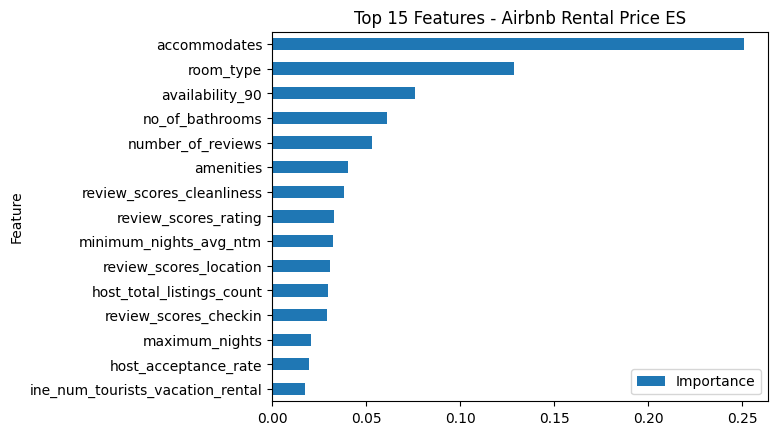

In [194]:
# Las primeras 15 columnas tienen una suma cumulativa de importancia de 0.861772
sorted_importances = feat_imp_redcols_2[:15].sort_values(by="Importance", ascending=True)
ax = sorted_importances.plot.barh(x="Feature", y="Importance")
ax.set_title("Top 15 Features - Airbnb Rental Price ES")
plt.show()

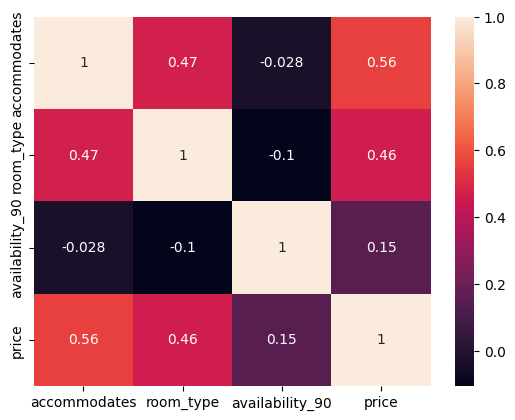

In [74]:
sns.heatmap(small_data_5[["accommodates", "room_type", "availability_90", "price"]].corr(),
            annot=True);

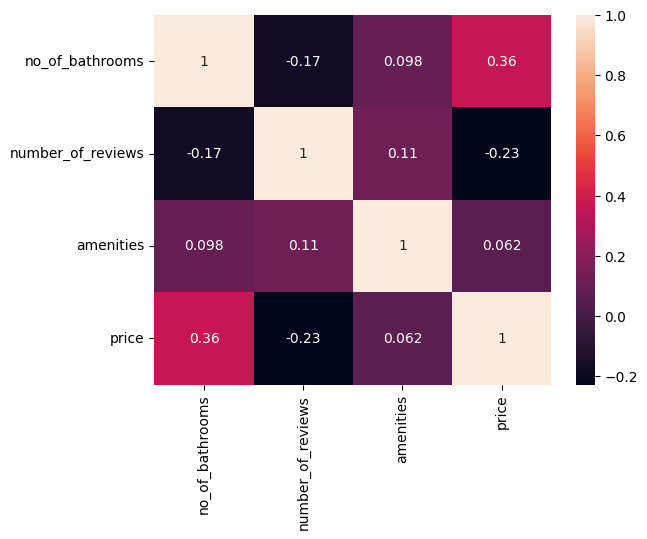

In [75]:
sns.heatmap(small_data_5[["no_of_bathrooms", "number_of_reviews", "amenities", "price"]].corr(),
            annot=True);

In [195]:
small_data_5["price"].describe()

count    804.000000
mean      99.054726
std       51.345381
min       20.000000
25%       62.750000
50%       90.000000
75%      125.000000
max      260.000000
Name: price, dtype: float64

In [196]:
small_data_5["bedrooms"].describe()

count    804.000000
mean       1.805970
std        0.922752
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: bedrooms, dtype: float64

In [197]:
small_data_5["no_of_bathrooms"].describe()

count    804.000000
mean       1.371269
std        0.574929
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.500000
Name: no_of_bathrooms, dtype: float64

Mira la distribución de precios

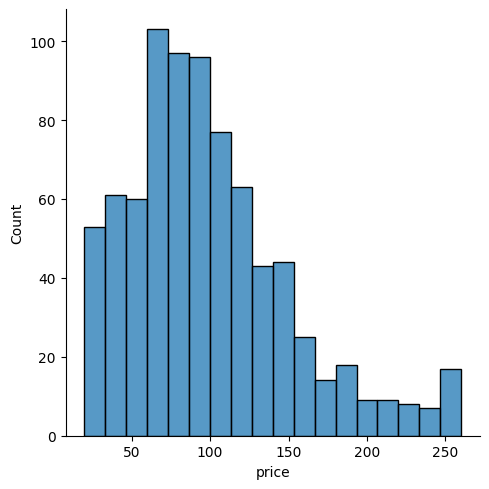

In [83]:
sns.displot(small_data_5["price"]);

Comentario:
- Los precios muestran una distribución sesgada a la derecha

Mira cuántos alojamientos tienen licencia turística

In [84]:
small_data_5.groupby("license")["id"].count()

license
0.0    272
1.0    532
Name: id, dtype: int64

In [86]:
small_data_5.groupby("license")["id"].count().sum()

804

In [87]:
532/804

0.6616915422885572

Comentario:
- Hay un 66% de alojamientos que tienen licencia turística.

Mira cuánto es el precio de alojamientos sin licencia y con licencia

In [60]:
small_data_5.groupby("license")["price"].mean()

license
0.0     89.963235
1.0    103.703008
Name: price, dtype: float64

In [80]:
small_data_5.groupby("license")["price"].median()

license
0.0    82.5
1.0    93.0
Name: price, dtype: float64

Comentario:
- El precio promedio de los alojamientos que tienen licencia turística es más alto que los que no tienen licencia

Mira el precio por cada noche mínima requerida

In [82]:
small_data_5.groupby("minimum_nights")["price"].mean()

minimum_nights
1      100.711538
2       92.825893
3       96.994220
4      101.914286
5      118.283784
6       97.611111
7      118.981481
8       73.500000
10     110.000000
14     112.428571
15     134.600000
20      97.333333
28      82.357143
29      60.500000
30      70.000000
31      87.052632
32      67.833333
60      75.400000
63      38.000000
64     106.000000
90      73.000000
120    100.000000
365    110.000000
Name: price, dtype: float64

In [81]:
small_data_5.groupby("minimum_nights")["price"].median()

minimum_nights
1       97.5
2       85.0
3       92.0
4       84.0
5      100.0
6       99.0
7      120.0
8       73.5
10     115.0
14     109.0
15     123.0
20      97.0
28      68.0
29      60.5
30      65.5
31      60.0
32      60.0
60      81.0
63      38.0
64     106.0
90      77.5
120    100.0
365    110.0
Name: price, dtype: float64

Referencias:
- Airbnb 90-day availability rule: [link1](https://www.elconfidencial.com/economia/2018-09-29/solo-el-15-de-los-airbnb-madrilenos-es-mas-rentable-que-los-alquileres-a-largo-plazo_1620414/), [link2](https://www.theupperkey.com/post/what-is-the-airbnb-90-day-rule#:~:text=The%20first%20option%20is%20to,fully%20compliant%20with%20the%20regulations.), [link3](https://www.houst.com/knowledge/the-90-day-airbnb-rule-and-what-it-means-to-you#:~:text=This%20means%20a%20property%20can,days%20spread%20throughout%20the%20year.)
- Airbnb ML Study Case: [Airbnb US](https://github.com/yoojin-kathleen/airbnb-price/blob/main/Team_11_Airbnb.ipynb)